In [ ]:
# Import Necessary Libraries
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import cudf
import cupy as cp
from scipy.sparse import csr_matrix
from cuml.svm import SVC as cuSVC
from cuml.ensemble import RandomForestClassifier as cuRF

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [ ]:
# Load training data and testing data
train_data = pd.read_csv('/kaggle/input/genre-classification/train.csv')

In [ ]:
test_data = pd.read_csv('/kaggle/input/genre-classification/test.csv')

In [ ]:
# Display train and test data
train_data.head(5)

In [ ]:
# Getting Unique Values of feature 'Genre'
train_data['Genre'].unique()

array(['Rock', 'Metal', 'Pop', 'Indie', 'R&B', 'Folk', 'Electronic',
       'Jazz', 'Hip-Hop', 'Country'], dtype=object)

In [ ]:
# Replacing Hip-Hop with HipHop
train_data['Genre'] = train_data['Genre'].str.replace('Hip-Hop', 'HipHop')
test_data['Genre'] = test_data['Genre'].str.replace('Hip-Hop', 'HipHop')

In [ ]:
# Filter train data and test data
genres = ['Rock', 'Jazz', 'HipHop', 'Metal', 'Country']
train_data = train_data[(train_data['Genre'].isin(genres)) & (train_data['Language'] == 'en')]
test_data = test_data[(test_data['Genre'].isin(genres))]
train_data = train_data[['Lyrics','Genre']]
test_data = test_data[['Lyrics','Genre']]

In [ ]:
# Pre-process train data using NLTK
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
# Function for pre-processing
def preprocess_text(text):
    text = re.sub(r'\@w+|\#','', text) # Remove @ and # from the text
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove all non-alphabetical characters (symbols and numbers) except spaces
    text = text.lower()
    tokens = word_tokenize(text) # Tokenize the text into individual words
    # Lemmatize each token (word) and remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)  # Join the tokens back into a single string with spaces

In [ ]:
# Apply Pre-processing on train and test data
train_data['Lyrics'] = train_data['Lyrics'].apply(preprocess_text)
test_data['Lyrics'] = test_data['Lyrics'].apply(preprocess_text)

In [ ]:
train_data.to_csv('cleaned_train_data.csv',index=False)
test_data.to_csv('cleaned_test_data.csv',index=False)

In [ ]:
# Load Saved Data
train_data = pd.read_csv('/kaggle/input/genre-classification/cleaned_train_data.csv')
test_data = pd.read_csv('/kaggle/input/genre-classification/cleaned_test_data.csv')

In [ ]:
train_data.head(5)

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,start pain followed hate fueled endless questi...
1,12 stones,broken,Rock,en,freedom alone alone patiently waiting phone ho...
2,12 stones,3 leaf loser,Rock,en,biting hand feed lying voice inside reach beg ...
3,12 stones,anthem for the underdog,Rock,en,say know cant imagine wait across line thought...
4,12 stones,adrenaline,Rock,en,heart beating faster cant control feeling anym...


In [ ]:
test_data.head(5)

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,craftsmanship,2005,buck-65,HipHop,folk spend day daydreaming finding clue whole ...,8294
2,riot,2013,bullet-for-my-valentine,Metal,ready time war well break fucking door smash w...,3301
4,believe-in-a-dollar,2012,cassidy,HipHop,believe magic young girl heart music free when...,16797
5,mama-bake-a-pie-daddy-kill-a-chicken,2007,bobby-bare,Country,people starin wheel ramp toward plane war ive ...,1251
6,thinking-about-you,2007,bill-monroe,Country,sigh hour away think love yesterday know shes ...,25217


In [ ]:
# Label encode genre
label_encoder = LabelEncoder()
train_data['Genre'] = label_encoder.fit_transform(train_data['Genre'])
test_data['Genre'] = label_encoder.transform(test_data['Genre'])

Initializing two types of vectorizers:  
CountVectorizer: Converts the lyrics into a bag-of-words model, limiting the features to 50,000.  
TfidfVectorizer: Converts the lyrics into a TF-IDF (Term Frequency-Inverse Document Frequency) representation.



In [ ]:
# Vectorize Data Using CountVectorizer and TFIDFVectorizer
count_vectorizer = CountVectorizer(max_features=50000)
tfidf_vectorizer = TfidfVectorizer(max_features=50000)

In [ ]:
# Transform to CountVectorizer
X_train_count = count_vectorizer.fit_transform(train_data['Lyrics'])
X_test_count = count_vectorizer.transform(test_data['Lyrics'])

In [ ]:
# Transform to TFIDF
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['Lyrics'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['Lyrics'])

In [ ]:
y_train = train_data['Genre']
y_test = test_data['Genre']

In [ ]:
# Function to Train and Evaluate Model
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name, vectorizer_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nClassification Report for {model_name} with {vectorizer_name}:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {model_name} with {vectorizer_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
# Define Models
logistic_regression = LogisticRegression(class_weight='balanced', max_iter=10000)
random_forest = RandomForestClassifier(class_weight='balanced')

# Logistic Regression


Classification Report for logistic_regression with count_vectorizer:
              precision    recall  f1-score   support

     Country       0.67      0.27      0.39       810
      HipHop       0.93      0.58      0.72       960
        Jazz       0.56      0.53      0.55       660
       Metal       0.60      0.74      0.66       810
        Rock       0.46      0.67      0.54      1410

    accuracy                           0.58      4650
   macro avg       0.64      0.56      0.57      4650
weighted avg       0.63      0.58      0.57      4650



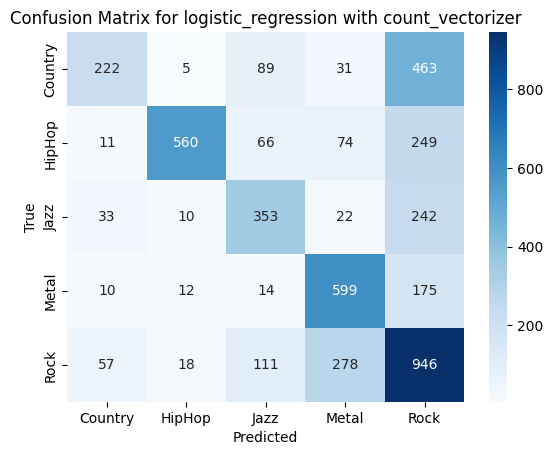

In [ ]:
train_and_evaluate(logistic_regression, X_train_count, X_test_count, y_train, y_test,"logistic_regression", 'count_vectorizer')


Classification Report for Logistic Regression with Tfidf Vectorizer:
              precision    recall  f1-score   support

     Country       0.63      0.47      0.54       810
      HipHop       0.92      0.78      0.84       960
        Jazz       0.57      0.52      0.55       660
       Metal       0.59      0.83      0.69       810
        Rock       0.53      0.55      0.54      1410

    accuracy                           0.63      4650
   macro avg       0.65      0.63      0.63      4650
weighted avg       0.64      0.63      0.63      4650



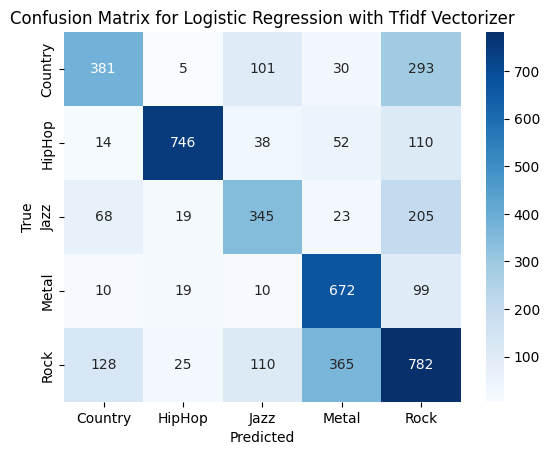

In [ ]:
train_and_evaluate(logistic_regression, X_train_tfidf, X_test_tfidf, y_train, y_test, 'Logistic Regression','Tfidf Vectorizer')

# Random Forest


Classification Report for Random Forest with Count Vectorizer:
              precision    recall  f1-score   support

     Country       0.88      0.02      0.03       810
      HipHop       0.97      0.25      0.39       960
        Jazz       0.92      0.32      0.47       660
       Metal       0.84      0.29      0.43       810
        Rock       0.35      0.97      0.52      1410

    accuracy                           0.44      4650
   macro avg       0.79      0.37      0.37      4650
weighted avg       0.74      0.44      0.38      4650



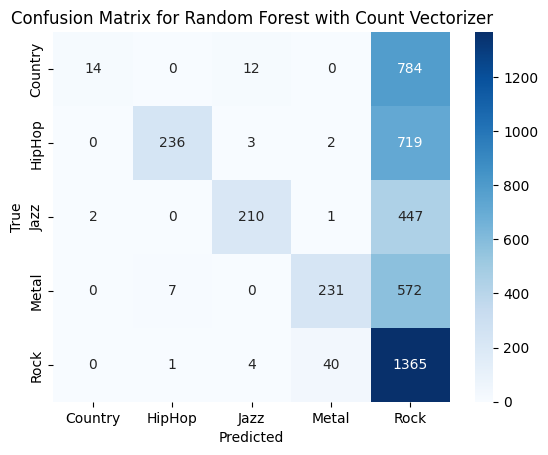

In [ ]:
train_and_evaluate(random_forest, X_train_count, X_test_count, y_train, y_test,'Random Forest','Count Vectorizer')


Classification Report for Random Forest with Tfidf Vectorizer:
              precision    recall  f1-score   support

     Country       1.00      0.01      0.02       810
      HipHop       0.98      0.24      0.38       960
        Jazz       0.93      0.30      0.46       660
       Metal       0.85      0.27      0.41       810
        Rock       0.35      0.97      0.51      1410

    accuracy                           0.44      4650
   macro avg       0.82      0.36      0.36      4650
weighted avg       0.76      0.44      0.37      4650



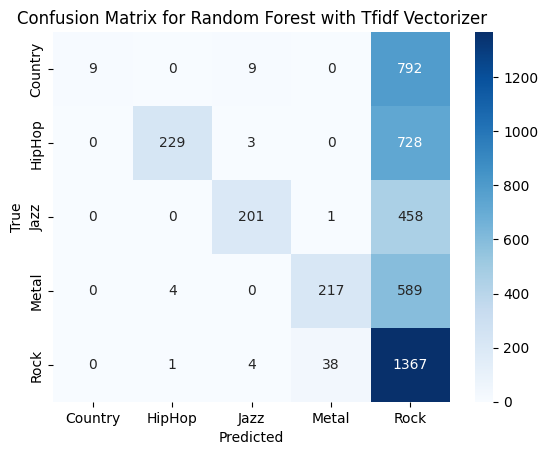

In [ ]:
train_and_evaluate(random_forest, X_train_tfidf, X_test_tfidf, y_train, y_test,'Random Forest','Tfidf Vectorizer')

# SVC (Using cuML)

Convert the csr_matrix format of the sparse feature matrices (X_train_count, X_train_tfidf) to cp.sparse.csr_matrix for compatibility with GPU-based operations and
Convert the labels (y_train, y_test) into CuPy arrays.

In [ ]:
# Convert data to float32 and CuPy sparse format
X_train_count_csr = csr_matrix(X_train_count, dtype=cp.float32)
X_test_count_csr = csr_matrix(X_test_count, dtype=cp.float32)

X_train_tfidf_csr = csr_matrix(X_train_tfidf, dtype=cp.float32)
X_test_tfidf_csr = csr_matrix(X_test_tfidf, dtype=cp.float32)

# Convert CSR matrix to CuPy sparse format
X_train_count_cupy = cp.sparse.csr_matrix(X_train_count_csr)
X_test_count_cupy = cp.sparse.csr_matrix(X_test_count_csr)

X_train_tfidf_cupy = cp.sparse.csr_matrix(X_train_tfidf_csr)
X_test_tfidf_cupy = cp.sparse.csr_matrix(X_test_tfidf_csr)

# Convert labels to CuPy arrays
y_train_cupy = cp.array(y_train.to_numpy(), dtype=cp.int32)
y_test_cupy = cp.array(y_test.to_numpy(), dtype=cp.int32)

In [ ]:
# Function to Train and Evaluate Model
def train_and_evaluate_cuml(model, X_train, X_test, y_train, y_test, model_name, vectorizer_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nClassification Report for {model_name} with {vectorizer_name}:")
    print(classification_report(cp.asnumpy(y_test), cp.asnumpy(y_pred), target_names=label_encoder.classes_))

    cm = confusion_matrix(cp.asnumpy(y_test), cp.asnumpy(y_pred))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {model_name} with {vectorizer_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
# Define cuML SVC model
cu_svc = cuSVC(probability=True, class_weight='balanced')

Train and evaluate cuML SVC using CountVectorizer and TfidfVectorizer data

[W] [23:38:04.404207] Sample weights are currently ignored for multi class classification
[W] [23:39:22.540973] Sample weights are currently ignored for multi class classification
[W] [23:40:40.669184] Sample weights are currently ignored for multi class classification
[W] [23:41:59.092856] Sample weights are currently ignored for multi class classification
[W] [23:43:17.035078] Sample weights are currently ignored for multi class classification

Classification Report for cuML SVC with Count Vectorizer:
              precision    recall  f1-score   support

     Country       0.56      0.56      0.56       810
      HipHop       0.82      0.86      0.84       960
        Jazz       0.58      0.56      0.57       660
       Metal       0.63      0.82      0.71       810
        Rock       0.57      0.46      0.51      1410

    accuracy                           0.64      4650
   macro avg       0.63      0.65      0.64      4650
weighted avg       0.63      0.64      0.63      4650



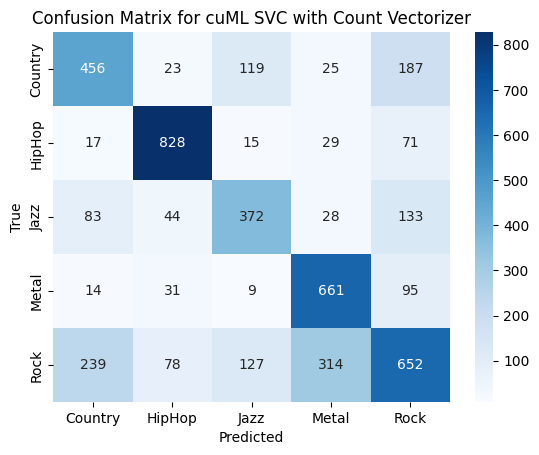

In [ ]:
train_and_evaluate_cuml(cu_svc, X_train_count_cupy, X_test_count_cupy, y_train_cupy, y_test_cupy, 'cuML SVC', 'Count Vectorizer')

[W] [00:08:50.186237] Sample weights are currently ignored for multi class classification
[W] [00:10:12.522955] Sample weights are currently ignored for multi class classification
[W] [00:11:39.626443] Sample weights are currently ignored for multi class classification
[W] [00:13:02.737509] Sample weights are currently ignored for multi class classification
[W] [00:14:25.939475] Sample weights are currently ignored for multi class classification

Classification Report for cuML SVC with Tfidf Vectorizer:
              precision    recall  f1-score   support

     Country       0.62      0.57      0.60       810
      HipHop       0.89      0.80      0.85       960
        Jazz       0.77      0.52      0.62       660
       Metal       0.70      0.78      0.74       810
        Rock       0.55      0.66      0.60      1410

    accuracy                           0.67      4650
   macro avg       0.71      0.67      0.68      4650
weighted avg       0.69      0.67      0.68      4650



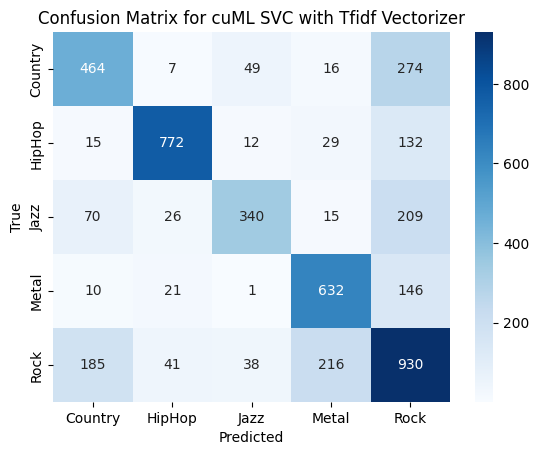

In [ ]:
# Train and evaluate cuML SVC using TfidfVectorizer data
train_and_evaluate_cuml(cu_svc, X_train_tfidf_cupy, X_test_tfidf_cupy, y_train_cupy, y_test_cupy, 'cuML SVC', 'Tfidf Vectorizer')

Conclusion: Of the models evaluated, the SVC showed the best performance when used with both CountVectorizer and TfidfVectorizer, achieving higher overall accuracy (64% and 67%, respectively) and a more balanced performance across most genres, especially for HipHop and Metal. In comparison, Logistic Regression and Random Forest faced challenges with specific genres like Country and Rock, yielding lower accuracy and uneven class-wise results. Although Logistic Regression was more consistent than Random Forest, SVC’s balanced results make it the most effective model for this dataset.